<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인공지능 가위바위보 

## Import : 필요한 라이브러리 가져오기

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import os, glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

## Load the dataset : 데이터 불러오기

### 구글 드라이브 연동

먼저 구글 드라이브를 연동 시킵니다.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


구글 드라이브를 연동 시키면 아래와 같이 gdrive 폴더가 생깁니다.  
저의 데이터들은 '/content/gdrive/MyDrive/Data/rock_scissor_paper'에 위치 하고 있습니다.

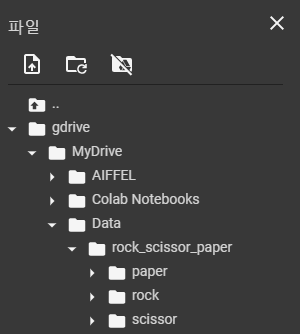

각각 불러와 압축을 풀어 줍시다.

In [16]:
!unzip -qq '/content/gdrive/MyDrive/Data/rock_scissor_paper/rock/rocks_complete.zip'
!unzip -qq '/content/gdrive/MyDrive/Data/rock_scissor_paper/scissor/scissors_complete.zip'
!unzip -qq '/content/gdrive/MyDrive/Data/rock_scissor_paper/paper/papers_complete.zip'

그럼 아래와 같이 데이터가 담긴 폴더가 생깁니다! 이렇게 하면 데이터에 접근할때 빠른 속도로 접근할 수 있습니다.

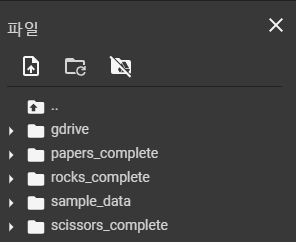

추가로 밑에 코드를 위해서 파일명도 바꿔주었습니다.

In [17]:
!mv papers_complete paper
!mv rocks_complete rock
!mv scissors_complete scissor

### 데이터 불러오기

본격적인 데이터를 불러오는 코드를 작성합시다.
아래의 코드는 **파일경로와 이미지 개수**를 입력하면 **이미지와 그에 따른 라벨**을 return 해줍니다.

In [18]:

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는", idx,"입니다.")
    return imgs, labels



그 전에 저희 데이터의 size는 224 X 224 인데 모델(MNIST를 돌렸던,,,)에 입력으로 들어가는 size는 28 X 28이기 때문에 resize를 해줘야합니다.

## Preprocessing : 데이터 전처리

### Resize 하기

In [19]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [20]:
image_dir_path = "/content"
image_dir_path_s = image_dir_path + "/scissor"
image_dir_path_r = image_dir_path + "/rock"
image_dir_path_p  = image_dir_path + "/paper"

resize_images(image_dir_path_s)
print("--가위 이미지 resize 완료!--")

resize_images(image_dir_path_r)
print("--바위 이미지 resize 완료!--")

resize_images(image_dir_path_p)
print("--보 이미지 resize 완료!--")

994  images to be resized.
994  images resized.
--가위 이미지 resize 완료!--
1105  images to be resized.
1105  images resized.
--바위 이미지 resize 완료!--
1108  images to be resized.
1108  images resized.
--보 이미지 resize 완료!--


### 정규화 하기

이제 데이터를 불러와 0~1 사이의 값으로 정규화를 해줍니다.

In [21]:
#데이터 불러오기
image_dir_path = "/content"
(X, y)=load_data(image_dir_path,3207)

# 입력은 0~1 사이의 값으로 정규화
X_norm = X/255.0 
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

이미지 개수는 3207 입니다.
X_train shape: (2565, 28, 28, 3)
y_train shape: (2565,)
X_test shape: (642, 28, 28, 3)
y_test shape: (642,)


잘 불러 왔는지 확인을 해봅시다!!

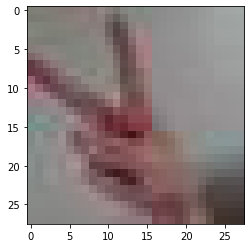

In [22]:
plt.imshow(X_train[44],cmap=plt.cm.binary)

## Build the model : 모델 구성하기

### configuring the layers

In [23]:
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

### compiling the model

In [24]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Train the model : 모델 학습시키기

In [25]:
model.fit(X_train, y_train, epochs=n_train_epoch)

Epoch 1/15
81/81 [==============================] - 32s 4ms/step - loss: 1.0869 - accuracy: 0.3712
Epoch 2/15
81/81 [==============================] - 0s 3ms/step - loss: 0.9393 - accuracy: 0.5559
Epoch 3/15
81/81 [==============================] - 0s 3ms/step - loss: 0.7865 - accuracy: 0.6456
Epoch 4/15
81/81 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.7314
Epoch 5/15
81/81 [==============================] - 0s 3ms/step - loss: 0.5249 - accuracy: 0.8016
Epoch 6/15
81/81 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.8429
Epoch 7/15
81/81 [==============================] - 0s 3ms/step - loss: 0.3440 - accuracy: 0.8784
Epoch 8/15
81/81 [==============================] - 0s 3ms/step - loss: 0.2653 - accuracy: 0.9158
Epoch 9/15
81/81 [==============================] - 0s 3ms/step - loss: 0.2136 - accuracy: 0.9341
Epoch 10/15
81/81 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.9435
Epoch 11/15
81/81 

## Evaluate accuracy : 정확도 측정하기

In [26]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

21/21 - 0s - loss: 0.1111 - accuracy: 0.9642
test_loss: 0.11107531934976578 
test_accuracy: 0.9641744494438171


96%로 꽤나 높은 정확도를 보여주고 있습니다.   
하지만 여기서 한번도 안보여준 데이터를 넣으면 어떻게 될까요?